In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [79]:
df_patients = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=0)
df_admissions = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=1)
df_icu_stays = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=2)
df_bypass_surgeries = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=3)
df_haemoglobins = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=4)
df_transfusions = pd.read_excel('Export 2022-10-22.xlsx', sheet_name=5)

In [80]:
# change metrics from g/l into g/dl
df_haemoglobins['REFERENCE_LOW'] = df_haemoglobins['REFERENCE_LOW']/10
df_haemoglobins['REFERENCE_HIGH'] = df_haemoglobins['REFERENCE_HIGH']/10
df_haemoglobins['RESULT'] = df_haemoglobins['RESULT']/10

In [81]:
df_transfusions = df_transfusions.dropna()

print(df_admissions["PATIENT_NUMBER"].nunique(),df_admissions["ADMISSION_NUMBER"].nunique())
print(len(df_bypass_surgeries["SURGERY_NUMBER"]),df_admissions["PATIENT_NUMBER"].nunique())

265 265
268 265


In [82]:
df_transfusions = pd.merge(df_transfusions,df_patients[["PATIENT_NUMBER","Gender"]], on=["PATIENT_NUMBER"],how = "inner")

In [83]:
df_transfusions.insert(1, 'blood_transfusion_counts', df_transfusions.groupby(['ADMISSION_NUMBER'])['BLOOD_START_TIME'].transform('count'))
df_transfusions



,TRANSFUSION_NUMBER,blood_transfusion_counts,PATIENT_NUMBER,ADMISSION_NUMBER,VOLUME,BLOOD_START_TIME,BLOOD_END_TIME,Gender
0,1,2,210,121,246.97,2021-12-19 12:01:00,2021-12-19 16:00:00,F
1,256,2,210,121,267.00,2021-12-16 15:11:00,2021-12-16 15:16:00,F
2,2,17,123,143,286.00,2021-07-02 16:18:00,2021-07-02 16:23:00,M
3,19,17,123,143,258.00,2021-07-02 05:51:00,2021-07-02 06:15:00,M
4,22,17,123,143,250.00,2021-07-01 22:51:00,2021-07-01 22:56:00,M
...,...,...,...,...,...,...,...,...
247,176,1,255,91,332.00,2022-03-30 01:25:00,2022-03-30 03:24:00,M
248,182,2,30,54,272.00,2022-07-21 11:54:00,2022-07-21 11:59:00,F
249,195,2,30,54,323.63,2022-07-23 12:42:00,2022-07-23 16:27:00,F
250,185,1,135,172,382.00,2022-04-08 03:49:00,2022-04-19 07:37:00,M


In [84]:
blood_transfusion_count = df_transfusions.blood_transfusion_counts.values
np.save('EPIC_blood_transfusion_count', blood_transfusion_count)

blood_transfusion_count_male = df_transfusions.loc[df_transfusions.Gender=='M'].blood_transfusion_counts.values
np.save('EPIC_blood_transfusion_count_male', blood_transfusion_count_male)

blood_transfusion_count_female = df_transfusions.loc[df_transfusions.Gender=='F'].blood_transfusion_counts.values
np.save('EPIC_blood_transfusion_count_female', blood_transfusion_count_female)

In [85]:
# the increase to additiona rows is caused by patient having multiple surgeries but it's ok
df_transfusions_merged= pd.merge(df_transfusions,df_bypass_surgeries[["PATIENT_NUMBER","ADMISSION_NUMBER","FINISH_TIME"]], on=["PATIENT_NUMBER","ADMISSION_NUMBER"],how = "inner")

In [86]:
## eliminate transfusion that's been done before the CABGsurgery is commenced
df_transfusions_merged = df_transfusions_merged.loc[df_transfusions_merged["BLOOD_START_TIME"] > df_transfusions_merged["FINISH_TIME"]]
## the update list shows that there are 67 patients that has underwent blood transfusion after surgery
df_transfusions_merged["PATIENT_NUMBER"].nunique()

65

In [87]:
## Q1, keep the earliest blood transfusion time for each patient, and search for the most recent hb test
first_transfusion = df_transfusions_merged.groupby(["PATIENT_NUMBER"])[["BLOOD_START_TIME","VOLUME","Gender"]].agg("min")
first_transfusion = pd.DataFrame(first_transfusion)


In [88]:
first_transfusion

,BLOOD_START_TIME,VOLUME,Gender
PATIENT_NUMBER,,,
6,2021-09-25 10:06:00,258.00,F
16,2022-04-10 17:59:00,271.97,M
17,2021-12-14 19:02:00,255.00,M
18,2022-04-05 17:50:00,250.00,M
23,2021-06-02 10:17:00,244.00,M
...,...,...,...
253,2021-09-01 10:20:00,261.00,M
255,2022-03-30 01:25:00,332.00,M
258,2021-11-29 12:26:00,247.00,M


In [89]:
first_blood_transfusion_volumn = first_transfusion.VOLUME.values
np.save('EPIC_first_blood_transfusion_volumn', first_blood_transfusion_volumn)

first_blood_transfusion_volumn_male = first_transfusion.loc[first_transfusion.Gender=='M'].VOLUME.values
np.save('EPIC_blood_transfusion_volumn_male', first_blood_transfusion_volumn_male)

first_blood_transfusion_volumn_female = first_transfusion.loc[first_transfusion.Gender=='F'].VOLUME.values
np.save('EPIC_blood_transfusion_volumn_female', first_blood_transfusion_volumn_female)

In [90]:
# the product of 2 timedate transforms the data into timedelta
## the hb value is the patient most recent hb value before the first blood transfusion
hb_value = []
for row_index, row in first_transfusion.iterrows():
    temp_df = df_haemoglobins.loc[df_haemoglobins["PATIENT_NUMBER"] == row_index] 
    ## find hb test that happened before the first blood transfusion
    temp_df = temp_df.loc[(row["BLOOD_START_TIME"]-temp_df["RESULT_TIME"]).dt.total_seconds() > 0]
    
    ## pick the most recent or the largest time 
    hb_value.append(float(temp_df.loc[temp_df["RESULT_TIME"] == temp_df["RESULT_TIME"].max()]["RESULT"]))
first_transfusion['pre_trans_hb'] = hb_value

In [91]:
first_transfusion

,BLOOD_START_TIME,VOLUME,Gender,pre_trans_hb
PATIENT_NUMBER,,,,
6,2021-09-25 10:06:00,258.00,F,7.6
16,2022-04-10 17:59:00,271.97,M,6.9
17,2021-12-14 19:02:00,255.00,M,7.4
18,2022-04-05 17:50:00,250.00,M,6.8
23,2021-06-02 10:17:00,244.00,M,6.7
...,...,...,...,...
253,2021-09-01 10:20:00,261.00,M,7.1
255,2022-03-30 01:25:00,332.00,M,7.3
258,2021-11-29 12:26:00,247.00,M,7.3


In [92]:
pre_transfusion = hb_value
np.save('EPIC_first_pre_transfusion', pre_transfusion)

first_pre_transfusion_male = first_transfusion.loc[first_transfusion.Gender == 'M'].pre_trans_hb.values
np.save('EPIC_first_pre_transfusion_male', first_pre_transfusion_male)

first_pre_transfusion_female = first_transfusion.loc[first_transfusion.Gender == 'F'].pre_trans_hb.values
np.save('EPIC_first_pre_transfusion_female', first_pre_transfusion_female)

mean is 7.42 and std is 0.73 and max is 10.9


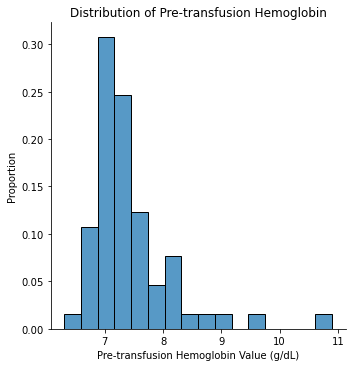

In [93]:
## plot for Q1
# sns.histplot(hb_value,stat="probability") 
sns.displot(data=first_transfusion, x="pre_trans_hb", stat="probability")
print(f'mean is {round(np.mean(first_transfusion.pre_trans_hb.values),2)} and std is {round(np.std(first_transfusion.pre_trans_hb.values),2)} and max is {round(np.max(first_transfusion.pre_trans_hb.values),2)}')
    
# sns.histplot(first_transfusion,x = "pre_trans_hb",stat="probability",element="step",common_norm=False)
plt.title('Distribution of Pre-transfusion Hemoglobin')
plt.xlabel("Pre-transfusion Hemoglobin Value (g/dL)")
plt.ylabel('Proportion')
plt.show()

In [18]:
## mean/std for the hb value of q1

print(np.mean(hb_value),np.std(hb_value))

7.424615384615384 0.7270659200313311


mean is 291.03 and std is 125.36


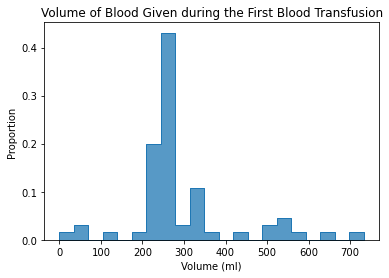

In [20]:
##q2
# sns.histplot(first_transfusion["VOLUME"],stat="probability")
sns.histplot(first_transfusion,x = "VOLUME",stat="probability",element="step",common_norm=False)
print(f'mean is {round(np.mean(first_transfusion.VOLUME.values),2)} and std is {round(np.std(first_transfusion.VOLUME.values),2)}')
    
plt.title('Volume of Blood Given during the First Blood Transfusion')
plt.xlabel("Volume (ml)")
plt.ylabel('Proportion')
plt.show()

In [78]:
# ## mean/std of total_volume
# np.mean(first_transfusion["VOLUME"])

291.03061538461543

For female mean is 305.65 and std is 104.16
For male mean is 287 and std is 130.3


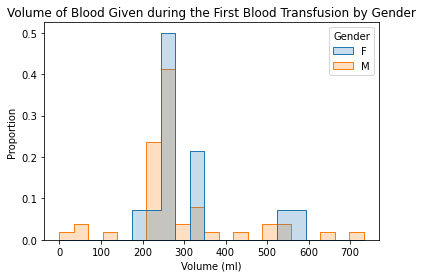

In [21]:
# ##q2 with gender
sns.histplot(first_transfusion,x = "VOLUME",stat="probability",hue = "Gender",element="step",common_norm=False)
female = first_transfusion.loc[first_transfusion['Gender'] =='F']
male = first_transfusion.loc[first_transfusion['Gender'] =='M']
print(f'For female mean is {round(np.mean(female.VOLUME.values),2)} and std is {round(np.std(female.VOLUME.values),2)}')
print(f'For male mean is {round(np.mean(male.VOLUME.values))} and std is {round(np.std(male.VOLUME.values),2)}')
      
plt.title('Volume of Blood Given during the First Blood Transfusion by Gender')
plt.xlabel("Volume (ml)")
plt.ylabel('Proportion')
plt.show()

In [98]:

print(np.mean(first_transfusion.loc[first_transfusion["Gender"] == "M"]["VOLUME"]))
print(np.std(first_transfusion.loc[first_transfusion["Gender"] == "M"]["VOLUME"]))
print(np.mean(first_transfusion.loc[first_transfusion["Gender"] == "F"]["VOLUME"]))
print(np.std(first_transfusion.loc[first_transfusion["Gender"] == "F"]["VOLUME"]))

287.01705882352945
130.2972243590139
305.65142857142854
104.16065996177956


In [99]:
difference = []
pretrans_value = []
for row_index, row in df_transfusions_merged.iterrows():
    temp_df = df_haemoglobins.loc[df_haemoglobins["PATIENT_NUMBER"] == row["PATIENT_NUMBER"]] 
    temp_df_pretrans = temp_df.loc[(row["BLOOD_START_TIME"]-temp_df["RESULT_TIME"]).dt.total_seconds() > 0]
    
    pretrans = float(temp_df_pretrans.loc[temp_df_pretrans["RESULT_TIME"] == temp_df_pretrans["RESULT_TIME"].max()]["RESULT"])
    pretrans_value.append(pretrans) 
    temp_df_postrans = temp_df.loc[(row["BLOOD_START_TIME"]-temp_df["RESULT_TIME"]).dt.total_seconds() < 0]
    postrans = float(temp_df_postrans.loc[temp_df_postrans["RESULT_TIME"] == temp_df_postrans["RESULT_TIME"].min()]["RESULT"])
    difference.append(round(postrans- pretrans,4))


In [100]:
df_transfusions_merged["hb_diff"] = difference
df_transfusions_merged["pre_trans_hb"] = pretrans_value

For female mean is 7.55 and std is 0.97
For male mean is 8 and std is 0.9


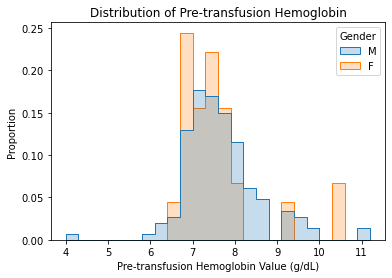

In [104]:
#q3 plot
sns.histplot(df_transfusions_merged.sort_values(by='Gender',ascending=False),x = "pre_trans_hb",stat="probability",hue = "Gender",element="step",common_norm=False)
female = df_transfusions_merged.loc[df_transfusions_merged['Gender'] =='F']
male = df_transfusions_merged.loc[df_transfusions_merged['Gender'] =='M']
print(f'For female mean is {round(np.mean(female.pre_trans_hb.values),2)} and std is {round(np.std(female.pre_trans_hb.values),2)}')
print(f'For male mean is {round(np.mean(male.pre_trans_hb.values))} and std is {round(np.std(male.pre_trans_hb.values),2)}')
   
plt.title('Distribution of Pre-transfusion Hemoglobin')
plt.xlabel("Pre-transfusion Hemoglobin Value (g/dL)")
plt.ylabel('Proportion')
plt.show()

In [26]:
# q3 mean/std based on gender
print(np.mean(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "M"]["pre_trans_hb"]))
print(np.std(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "M"]["pre_trans_hb"]))
print(np.mean(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "F"]["pre_trans_hb"]))
print(np.std(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "F"]["pre_trans_hb"]))

7.607482993197274
0.9017811879470865
7.553333333333334
0.9708186694171517


mean is 0.81 and std is 1.13


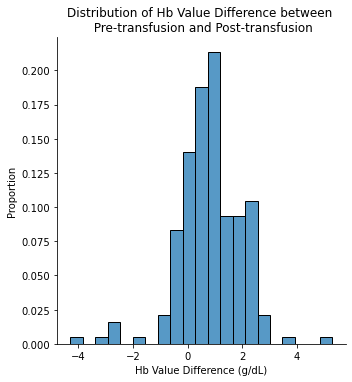

In [106]:
#plot of question 4
# sns.histplot(df_transfusions_merged, x = "hb_diff",stat="probability") 
sns.displot(data=df_transfusions_merged, x="hb_diff", stat="probability")
# sns.histplot(df_transfusions_merged,x = "hb_diff",stat="probability",element="step",common_norm=False)
print(f'mean is {round(np.mean(df_transfusions_merged.hb_diff.values),2)} and std is {round(np.std(df_transfusions_merged.hb_diff.values),2)}')

plt.title('Distribution of Hb Value Difference between \n Pre-transfusion and Post-transfusion')
plt.xlabel("Hb Value Difference (g/dL)")
plt.ylabel('Proportion')
plt.show()

In [28]:
print(np.mean(df_transfusions_merged["hb_diff"]))
print(np.std(df_transfusions_merged["hb_diff"]))

0.8104166666666665
1.1279571474080432


In [29]:
df_transfusions_merged= df_transfusions_merged.sort_values(by=['Gender'] ,ascending = False)

For female mean is 0.78 and std is 1.32
For male mean is 1 and std is 1.06


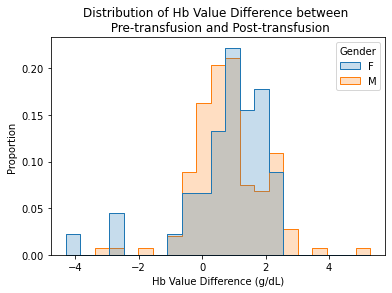

In [107]:
#plot for questions 5
## it seems to indicate that there are female patient that suffers from severer blood loss which require multiple blood transfusion
## there are 45 instances of female blood transfusion, and patient number holds the majority of the numbers of 25, this essentially
## makes the female density seems to have a high anoumaly because the hypothesis should be that female will have a positive increase
## in the diffrence between pre transfusion and post
sns.histplot(df_transfusions_merged,x = "hb_diff",stat="probability",hue = "Gender",element="step",common_norm=False)
female = df_transfusions_merged.loc[df_transfusions_merged['Gender'] =='F']
male = df_transfusions_merged.loc[df_transfusions_merged['Gender'] =='M']
print(f'For female mean is {round(np.mean(female.hb_diff.values),2)} and std is {round(np.std(female.hb_diff.values),2)}')
print(f'For male mean is {round(np.mean(male.hb_diff.values))} and std is {round(np.std(male.hb_diff.values),2)}')

plt.title('Distribution of Hb Value Difference between \n Pre-transfusion and Post-transfusion')
plt.xlabel("Hb Value Difference (g/dL)")
plt.ylabel('Proportion')
plt.show()

In [33]:
print(np.mean(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "M"]["hb_diff"]))
print(np.std(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "M"]["hb_diff"]))
print(np.mean(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "F"]["hb_diff"]))
print(np.std(df_transfusions_merged.loc[df_transfusions_merged["Gender"] == "F"]["hb_diff"]))

0.8204081632653059
1.0605439995112638
0.7777777777777778
1.3239484529893295


In [34]:
df_transfusions_merged
pre_transfusion = df_transfusions_merged.pre_trans_hb.values
np.save('EPIC_pre_transfusion', pre_transfusion)

pre_transfusion_male = df_transfusions_merged.loc[df_transfusions_merged.Gender == 'M'].pre_trans_hb.values
np.save('EPIC_pre_transfusion_male', pre_transfusion_male)

pre_transfusion_female = df_transfusions_merged.loc[df_transfusions_merged.Gender == 'F'].pre_trans_hb.values
np.save('EPIC_pre_transfusion_female', pre_transfusion_female)


value_diff = df_transfusions_merged.hb_diff.values
np.save('EPIC_value_diff', value_diff)

value_diff_male = df_transfusions_merged.loc[df_transfusions_merged.Gender == 'M'].hb_diff.values
np.save('EPIC_value_diff_male', value_diff_male)

value_diff_female = df_transfusions_merged.loc[df_transfusions_merged.Gender == 'F'].hb_diff.values
np.save('EPIC_value_diff_female', value_diff_female)

In [35]:
# plot for self investigated EDA 
# number of hb measure in the first 24 hours of ICU
# correaltion between hb difference in pre transfusion value



In [36]:
# time diffrence between pre transfusion and blood transfusion 
time = []

for row_index, row in df_transfusions_merged.iterrows():
    temp_df = df_haemoglobins.loc[df_haemoglobins["PATIENT_NUMBER"] == row["PATIENT_NUMBER"]] 
    temp_df_pretrans = temp_df.loc[(row["BLOOD_START_TIME"]-temp_df["RESULT_TIME"]).dt.total_seconds() > 0]
    pretrans = temp_df_pretrans.loc[temp_df_pretrans["RESULT_TIME"] == temp_df_pretrans["RESULT_TIME"].max()]["RESULT_TIME"]
    pretrans = round(float((row["BLOOD_START_TIME"] -pretrans).dt.total_seconds()/60),2)
    time.append(pretrans)
df_transfusions_merged["time"] = time

In [37]:
first_transfusion = df_transfusions_merged.groupby(["PATIENT_NUMBER"])[["BLOOD_START_TIME","VOLUME","Gender","time"]].agg("min")
first_transfusion = first_transfusion.sort_values(by=['Gender'] ,ascending = False)

mean is 130.81 and std is 223.36


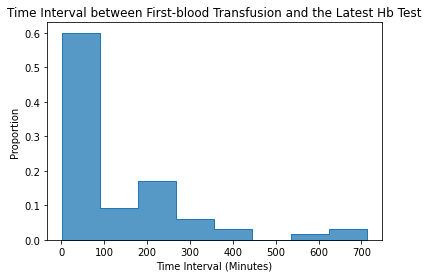

In [39]:
## time interval using gender 
# sns.histplot(first_transfusion,x = "time",stat="probability")
sns.histplot(first_transfusion,x = "time",stat="probability",element="step",common_norm=False)
print(f'mean is {round(np.mean(df_transfusions_merged.time.values),2)} and std is {round(np.std(df_transfusions_merged.time.values),2)}')

plt.title('Time Interval between First-blood Transfusion and the Latest Hb Test')
plt.xlabel("Time Interval (Minutes)")
plt.ylabel('Proportion')
plt.show()

In [40]:
np.mean(first_transfusion["time"])

129.33846153846153

For female mean is 103.22 and std is 141.52
For male mean is 139 and std is 242.34


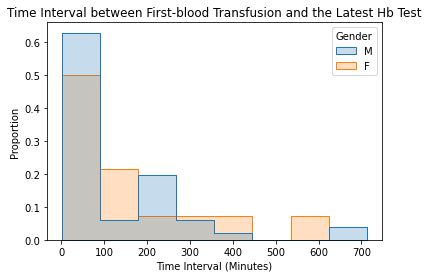

In [41]:
sns.histplot(first_transfusion,x = "time",stat="probability",hue = "Gender",element="step",common_norm=False)
female = df_transfusions_merged.loc[df_transfusions_merged['Gender'] =='F']
male = df_transfusions_merged.loc[df_transfusions_merged['Gender'] =='M']
print(f'For female mean is {round(np.mean(female.time.values),2)} and std is {round(np.std(female.time.values),2)}')
print(f'For male mean is {round(np.mean(male.time.values))} and std is {round(np.std(male.time.values),2)}')

plt.title('Time Interval between First-blood Transfusion and the Latest Hb Test')
plt.xlabel("Time Interval (Minutes)")
plt.ylabel('Proportion')
plt.show()

In [42]:
first_transfusion

,BLOOD_START_TIME,VOLUME,Gender,time
PATIENT_NUMBER,,,,
150,2021-05-19 19:55:00,277.08,M,53.0
135,2022-04-08 03:49:00,382.00,M,188.0
16,2022-04-10 17:59:00,271.97,M,712.0
161,2021-12-14 11:40:00,257.00,M,52.0
163,2022-04-21 09:41:00,440.00,M,197.0
...,...,...,...,...
228,2022-03-27 16:07:00,255.00,F,51.0
210,2021-12-19 12:01:00,246.97,F,95.0
181,2022-03-31 02:48:00,231.00,F,2.0


In [43]:
time_first_pre_transfusion = first_transfusion.time.values
np.save('EPIC_time_first_pre_transfusion', time_first_pre_transfusion)

time_first_pre_transfusion_male = first_transfusion.loc[first_transfusion.Gender == 'M'].time.values
np.save('EPIC_time_first_pre_transfusion_male', time_first_pre_transfusion_male)

time_first_pre_transfusion_female = first_transfusion.loc[first_transfusion.Gender == 'F'].time.values
np.save('EPIC_time_first_pre_transfusion_female', time_first_pre_transfusion_female)

In [44]:
print(np.mean(first_transfusion.loc[first_transfusion["Gender"] == "M"]["time"]))
print(np.std(first_transfusion.loc[first_transfusion["Gender"] == "M"]["time"]))
print(np.mean(first_transfusion.loc[first_transfusion["Gender"] == "F"]["time"]))
print(np.std(first_transfusion.loc[first_transfusion["Gender"] == "F"]["time"]))

122.86274509803921
151.34754441452816
152.92857142857142
171.55360023940634


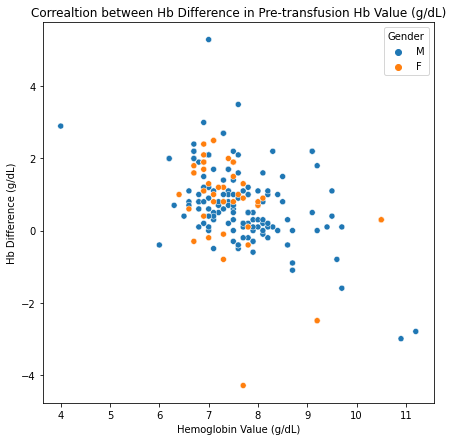

In [47]:
## correaltion between hb difference in pre transfusion hb value
plt.figure(figsize=(7,7))
sns.scatterplot(data = df_transfusions_merged, y = "hb_diff", x='pre_trans_hb',hue="Gender")
plt.title('Correaltion between Hb Difference in Pre-transfusion Hb Value (g/dL)')
plt.xlabel("Hemoglobin Value (g/dL)")
plt.ylabel('Hb Difference (g/dL)')
plt.show()

In [48]:
## number of hb measure in the first 24 hours of ICU
## duplicate rows with same patient_num+admission num but different ICU_stay num
df_icu = df_icu_stays
df_icu = pd.merge(df_icu,df_patients[["PATIENT_NUMBER","Gender"]], on=["PATIENT_NUMBER"],how = "inner")


In [49]:
hb_measure = []

for row_index, row in df_icu.iterrows():
    temp_df = df_haemoglobins.loc[df_haemoglobins["PATIENT_NUMBER"] == row["PATIENT_NUMBER"]] 
    temp_df = temp_df.loc[temp_df["RESULT_TIME"] <= row["ICU_START_TIME"]+datetime.timedelta(days=1)]
    temp_df = temp_df.loc[temp_df["RESULT_TIME"] > row["ICU_START_TIME"]]
    hb_measure.append(len(temp_df))

df_icu["hb_measure"] = hb_measure

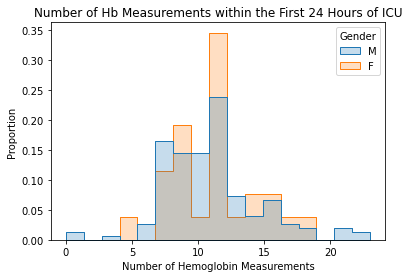

In [52]:
sns.histplot(df_icu,x = "hb_measure",stat="probability",hue = "Gender",element="step",common_norm=False)
plt.title('Number of Hb Measurements within the First 24 Hours of ICU')
plt.xlabel("Number of Hemoglobin Measurements")
plt.ylabel('Proportion')
plt.show()

In [108]:
print(np.mean(df_icu["hb_measure"]))
print(np.mean(df_icu.loc[df_icu["Gender"] == "M"]["hb_measure"]))
print(np.std(df_icu.loc[df_icu["Gender"] == "M"]["hb_measure"]))
print(np.mean(df_icu.loc[df_icu["Gender"] == "F"]["hb_measure"]))
print(np.std(df_icu.loc[df_icu["Gender"] == "F"]["hb_measure"]))

11.07909604519774
11.026490066225165
3.5527193574335163
11.384615384615385
3.0009860312509473


In [109]:
df_icu['icu_stay_time'] = (df_icu['ICU_END_TIME'] - df_icu['ICU_START_TIME']).dt.seconds/3600
df_icu

,ICU_STAY_NUMBER,PATIENT_NUMBER,ADMISSION_NUMBER,ICU_START_TIME,ICU_END_TIME,Gender,hb_measure,icu_stay_time
0,1,87,115,2021-08-05 17:49:00,2021-08-06 12:22:00,M,12,18.550000
1,2,192,245,2021-08-23 13:50:00,2021-08-25 16:49:00,M,10,2.983333
2,3,224,170,2021-11-17 17:31:00,2021-11-18 15:57:00,M,14,22.433333
3,4,88,31,2022-02-14 12:58:00,2022-02-15 13:13:00,M,12,0.250000
4,5,223,160,2021-12-03 12:55:00,2021-12-04 15:53:00,M,11,2.966667
...,...,...,...,...,...,...,...,...
172,172,125,202,2021-04-29 13:41:00,2021-04-30 18:51:00,M,9,5.166667
173,173,173,16,2021-06-23 13:26:00,2021-06-24 15:10:00,M,8,1.733333
174,174,142,162,2021-10-23 11:51:00,2021-10-24 19:11:00,M,6,7.333333
175,175,240,159,2022-05-04 17:07:00,2022-05-05 16:52:00,M,12,23.750000


In [110]:
EPIC_icu_stay_time = df_icu.icu_stay_time.values
np.save('EPIC_icu_stay_time_days', EPIC_icu_stay_time)

EPIC_icu_stay_time_male = df_icu.loc[df_icu.Gender == 'M'].icu_stay_time.values
np.save('EPIC_icu_stay_time_days_male', EPIC_icu_stay_time_male)

EPIC_icu_stay_time_female =df_icu.loc[df_icu.Gender == 'F'].icu_stay_time.values
np.save('EPIC_icu_stay_time_days_female', EPIC_icu_stay_time_female)


In [111]:
df_icu

,ICU_STAY_NUMBER,PATIENT_NUMBER,ADMISSION_NUMBER,ICU_START_TIME,ICU_END_TIME,Gender,hb_measure,icu_stay_time
0,1,87,115,2021-08-05 17:49:00,2021-08-06 12:22:00,M,12,18.550000
1,2,192,245,2021-08-23 13:50:00,2021-08-25 16:49:00,M,10,2.983333
2,3,224,170,2021-11-17 17:31:00,2021-11-18 15:57:00,M,14,22.433333
3,4,88,31,2022-02-14 12:58:00,2022-02-15 13:13:00,M,12,0.250000
4,5,223,160,2021-12-03 12:55:00,2021-12-04 15:53:00,M,11,2.966667
...,...,...,...,...,...,...,...,...
172,172,125,202,2021-04-29 13:41:00,2021-04-30 18:51:00,M,9,5.166667
173,173,173,16,2021-06-23 13:26:00,2021-06-24 15:10:00,M,8,1.733333
174,174,142,162,2021-10-23 11:51:00,2021-10-24 19:11:00,M,6,7.333333
175,175,240,159,2022-05-04 17:07:00,2022-05-05 16:52:00,M,12,23.750000


In [114]:
def boxplot_icu_stay_time(df,name):
    
    
    sns.histplot(df, x="icu_stay_time", element="step",
    stat="probability", common_norm=False,)  
    plt.title("Distribution of ICU Stay Time")
    plt.ylabel('Proportion')
    plt.xlabel('ICU Stay Time (Minutes)')
    plt.show()
    plt.figure(figsize=(7,7))
    sns.boxplot(data=df, y="icu_stay_time")
    print(f'mean is {round(np.mean(df.icu_stay_time.values),2)} and std is {round(np.std(df.icu_stay_time.values),2)}')
    #sns.histplot(data=icu_stay_time_blood_counts, x="icu_stay_time")
    plt.title("ICU Stay Time Distribution")
    plt.ylabel('ICU Stay Time (Minutes)')
    plt.savefig(f'Additional_CABG_plots/{name}_boxtplot_icu_stay_time.png')
    plt.show()

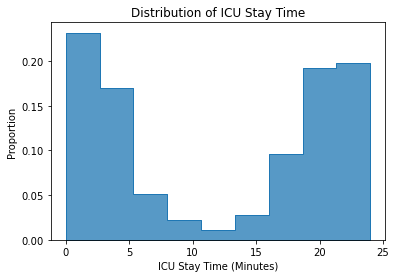

mean is 12.0 and std is 8.79


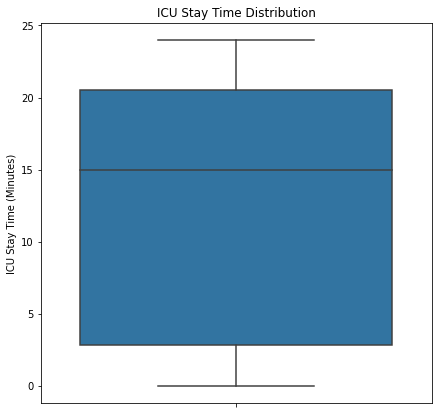

In [115]:
boxplot_icu_stay_time(df_icu,"EPIC")

In [66]:
EPIC_hemoglobin_24h_Hb_count = df_icu.hb_measure.values
np.save('EPIC_hemoglobin_24h_Hb_count', EPIC_hemoglobin_24h_Hb_count)

EPIC_hemoglobin_24h_Hb_count_male = df_icu.loc[df_icu.Gender == 'M'].hb_measure.values
np.save('EPIC_hemoglobin_24h_Hb_count_male', EPIC_hemoglobin_24h_Hb_count_male)

EPIC_hemoglobin_24h_Hb_count_female =df_icu.loc[df_icu.Gender == 'F'].hb_measure.values
np.save('EPIC_hemoglobin_24h_Hb_count_female', EPIC_hemoglobin_24h_Hb_count_female)

In [94]:
def histplot_24H_Hb_measurement(df,name):
    # without gender
#     plt.figure(figsize=(7,7))
#     sns.displot(data=df, x="counts", stat="probability")
#     sns.histplot(data=df, x="counts", kde=True)
    sns.histplot(df, x="counts", element="step",
    stat="probability", common_norm=False,bins=14)  
    print(f'mean is {round(np.mean(df.counts.values),2)} and std is {round(np.std(df.counts.values),2)}')

    plt.title('Number of Hemoglobin Measurements from \n the Beginning of the Surgery to the First 24 Hours of the Intensive Care')
    plt.xlabel('Number of Hemoglobin Measurements')
    plt.ylabel('Proportion')
    plt.savefig(f'Additional_Hb_plots/histplot_numberOfHBmeasurement24H.png')
    plt.show() 
    
    
    # for gender
    sns.histplot(df, x="counts", hue="gender", element="step",
    stat="probability", common_norm=False,bins=14)  
    female = df.loc[df['gender'] =='F']
    male = df.loc[df['gender'] =='M']
    print(f'For female mean is {round(np.mean(female.counts.values),2)} and std is {round(np.std(female.counts.values),2)}')
    print(f'For male mean is {round(np.mean(male.counts.values))} and std is {round(np.std(male.counts.values),2)}')
   
    plt.title('Number of Hemoglobin Measurements from \n the Beginning of the Surgery to the First 24 Hours of the Intensive Care')
    plt.xlabel('Number of Hemoglobin Measurements')
    plt.ylabel('Proportion')
    plt.savefig(f'Additional_Hb_plots/histplot_numberOfHBmeasurement24H_gender.png')
    plt.show()
    
    
    
    sns.boxplot(x="gender", y='counts', data=df)
    plt.title("Number of Hemoglobin Measurements")
    plt.ylabel('Number of Hemoglobin Measurements')
    plt.savefig(f'Additional_Hb_plots/boxplot_numberOfHBmeasurement24H_gender.png')
    plt.show()



In [69]:
df_icu

,ICU_STAY_NUMBER,PATIENT_NUMBER,ADMISSION_NUMBER,ICU_START_TIME,ICU_END_TIME,Gender,hb_measure,icu_stay_time
0,1,87,115,2021-08-05 17:49:00,2021-08-06 12:22:00,M,12,18.550000
1,2,192,245,2021-08-23 13:50:00,2021-08-25 16:49:00,M,10,2.983333
2,3,224,170,2021-11-17 17:31:00,2021-11-18 15:57:00,M,14,22.433333
3,4,88,31,2022-02-14 12:58:00,2022-02-15 13:13:00,M,12,0.250000
4,5,223,160,2021-12-03 12:55:00,2021-12-04 15:53:00,M,11,2.966667
...,...,...,...,...,...,...,...,...
172,172,125,202,2021-04-29 13:41:00,2021-04-30 18:51:00,M,9,5.166667
173,173,173,16,2021-06-23 13:26:00,2021-06-24 15:10:00,M,8,1.733333
174,174,142,162,2021-10-23 11:51:00,2021-10-24 19:11:00,M,6,7.333333
175,175,240,159,2022-05-04 17:07:00,2022-05-05 16:52:00,M,12,23.750000


In [72]:

def histplot_hb_measure(df,name):
    
    sns.histplot(df, x="hb_measure", element="step",
    stat="probability", common_norm=False,)
    print(f'mean is {round(np.mean(df.hb_measure.values),2)} and std is {round(np.std(df.hb_measure.values),2)}')
    
    plt.title('Number of Hb Measurements within the First 24 Hours of ICU')
    plt.xlabel("Amount of Hemoglobin Measurements")
    plt.ylabel('Proportion')
#     plt.savefig(f'Bloodtransfusion_plots/{name}_histplot_numberOfbloodTransfusion.png')
    plt.show()
    
 
    sns.histplot(df, x="hb_measure", hue="Gender", element="step",
    stat="probability", common_norm=False,)
    female = df.loc[df['Gender'] =='F']
    male = df.loc[df['Gender'] =='M']
    print(f'For female mean is {round(np.mean(female.hb_measure.values),2)} and std is {round(np.std(female.hb_measure.values),2)}')
    print(f'For male mean is {round(np.mean(male.hb_measure.values))} and std is {round(np.std(male.hb_measure.values),2)}')
              
    plt.title('Number of Hb Measurements within the First 24 Hours of ICU')
    plt.xlabel("Amount of Hemoglobin Measurements")
    plt.ylabel('Proportion')
#     plt.savefig(f'Bloodtransfusion_plots/{name}_histplot_numberOfbloodTransfusion_gender.png')
    plt.show()
    
    


    sns.boxplot(x="Gender", y='hb_measure', data=df)
    plt.title('Number of Hb Measurements within the First 24 Hours of ICU')
    plt.ylabel("Amount of Hemoglobin Measurements")
#     plt.ylabel('Proportion')
#     plt.savefig(f'Bloodtransfusion_plots/{name}_boxplot_numberOfbloodTransfusion_gender.png')
    plt.show()
    

mean is 11.08 and std is 3.48


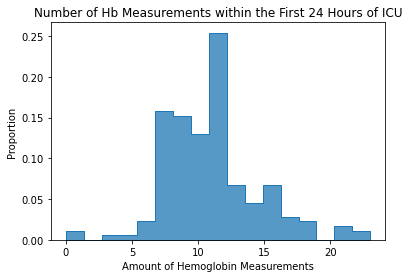

For female mean is 11.38 and std is 3.0
For male mean is 11 and std is 3.55


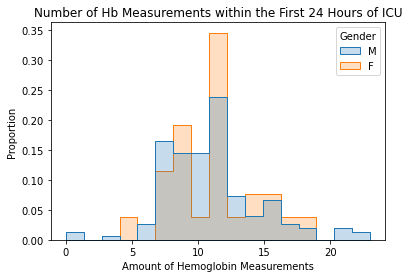

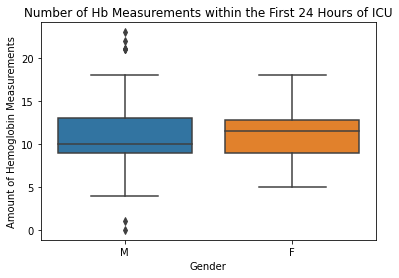

In [73]:
histplot_hb_measure(df_icu,'EPIC')

In [74]:
df_transfusions = df_transfusions.sort_values(by=['Gender'] ,ascending = False)
histplot_bloodtransfusion_counts(df_transfusions,"EPIC")
# # boxplot_bloodtransfusion_counts(blood_transfusion_count,"MIMIC")
df_transfusions

NameError: name 'histplot_bloodtransfusion_counts' is not defined

In [159]:
df_transfusions_merged = df_transfusions_merged.rename(columns = {'ADMISSION_NUMBER':'hadm_id','Gender':'gender','hb_diff':'value_diff','pre_trans_hb':'pre_transfusion','blood_transfusion_counts':'blood_counts'})


In [75]:
def multiline_Pretransfusion_Bloodtransfusion(df,name):
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Pre-transfusion value for patient with different number of blood transfusion')


    for axes_num1 in range(3):

        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]


        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['pre_transfusion'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().pre_transfusion

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)))

        axes[2].set_xlabel("Pre-transfusion value")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_Pretransfusion_Bloodtransfusion.png')
    fig.show()

def multiline_Pretransfusion_Bloodtransfusion_gender(df,name):
    row = 3
    col = 1
    fig, axes = plt.subplots(row,sharex=True, figsize=(16,8))
    fig.suptitle('Pre-transfusion value for patient with different number of blood transfusion')


    for axes_num1 in range(3):
        count = axes_num1+1

        if(count==3):
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts >= count)]
        else:
            partial_fbt_time_differece_Hb = df.loc[(df.blood_counts == count)]

        male_Hb = partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'M']
        sns.kdeplot(ax=axes[axes_num1],x=male_Hb['pre_transfusion'], label='male')
        female_Hb =partial_fbt_time_differece_Hb[partial_fbt_time_differece_Hb.gender == 'F']
        sns.kdeplot(ax=axes[axes_num1],x=female_Hb['pre_transfusion'],label='female')
        sns.kdeplot(ax=axes[axes_num1],x= partial_fbt_time_differece_Hb['pre_transfusion'],label='All')
        mean= partial_fbt_time_differece_Hb.mean().pre_transfusion
        fmean = female_Hb.pre_transfusion.mean()
        mmean= male_Hb.pre_transfusion.mean()

        if(count==3):
            axes[axes_num1].set_title('Blood transfusion >='+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+ '| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) + '| M Mean '+str(round(mmean,3)))
        else:
            axes[axes_num1].set_title('Blood transfusion '+str(count)+ '|Patients '+str(len(partial_fbt_time_differece_Hb))+'| Mean ' + str(round(mean,3)) +'| F Mean '+str(round(fmean,3)) + '| M Mean '+str(round(mmean,3)))


        axes[2].set_xlabel("Pre-transfusion value")
        axes[axes_num1].legend(loc='upper right')
    fig.savefig(f'labevent_plots/{name}_multiline_Pretransfusion_Bloodtransfusion_gender.png')
    fig.show()

AttributeError: 'DataFrame' object has no attribute 'blood_counts'

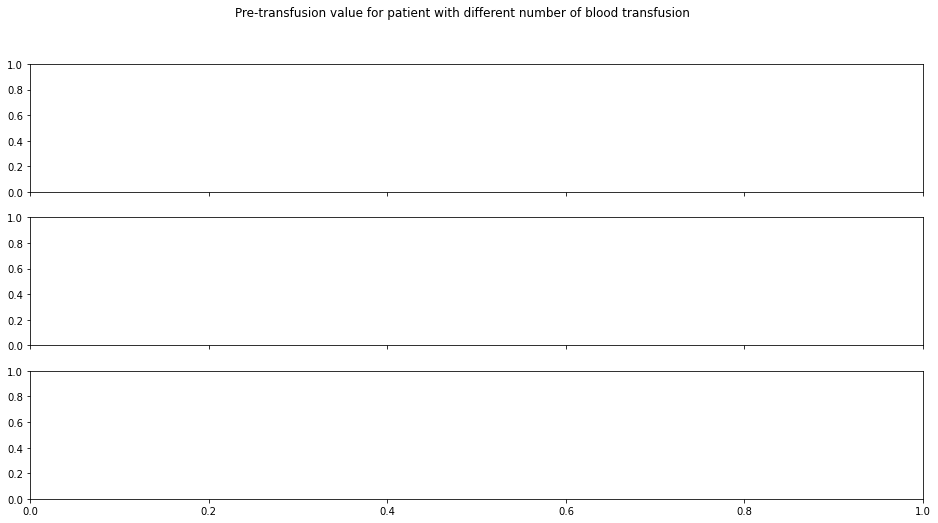

In [76]:
multiline_Pretransfusion_Bloodtransfusion(df_transfusions_merged,'EPIC')
multiline_Pretransfusion_Bloodtransfusion_gender(df_transfusions_merged,'EPIC')